## Start from importing lots of stuff

In [1]:
import numpy
import astropy
from astropy.io import ascii
from astropy.table import Table

# Activating plotting
import matplotlib.pyplot as plt
%matplotlib inline

# things we already know
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# things we learn today
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVC, SVR

## Decision tree 

<img src='http://cdn.edureka.co/blog/wp-content/uploads/2015/01/tree2.png' width=600 />

## Decision Tree for regression (DEMO)

### Plotting decision rules

decision rule is piecewise-constant

In [2]:
# Create a random dataset. 
rng = numpy.random.RandomState(1) # This is the way to get the same dataset each time
X_toy = numpy.sort(5 * rng.rand(80, 1), axis=0)
y_toy = numpy.sin(X_toy).ravel() + rng.laplace(size=80) * 0.2

In [3]:
# loading additional functions from utils.py
# those will help with visualization
from utils import plot_regressor_decision, plot_classifier_decision, plot_regressor_decision_2d

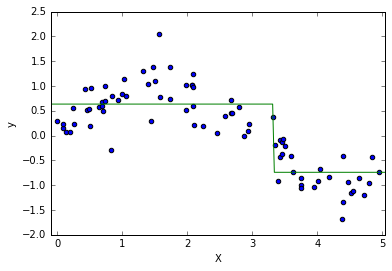

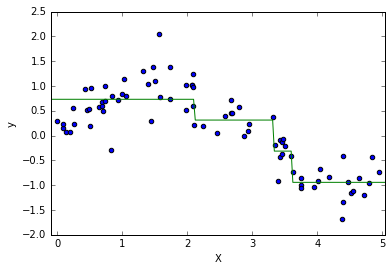

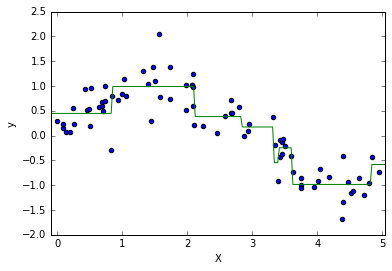

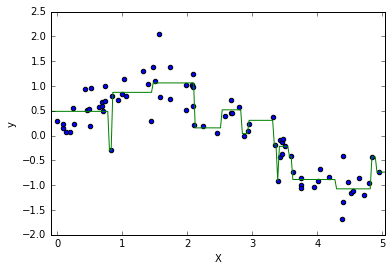

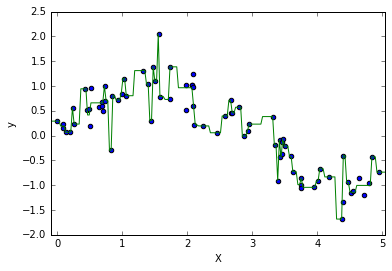

In [4]:
for depth in [1, 2, 3, 4, 8]:
    tree_reg = DecisionTreeRegressor(max_depth=depth).fit(X_toy, y_toy)
    plot_regressor_decision(tree_reg, X_toy, y_toy)
    plt.xlabel('X')
    plt.ylabel('y')
    plt.show()

## Decision trees for classification

(<matplotlib.text.Text at 0x1127a1810>, <matplotlib.text.Text at 0x1127b0c90>)

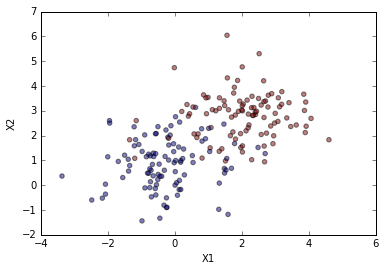

In [5]:
# generate two classes with features
from sklearn.datasets import make_blobs

X_toy, y_toy = make_blobs(n_samples=200, centers=[[0, 1], [2, 3]], random_state=14)
plt.scatter(X_toy[:, 0], X_toy[:, 1], c=y_toy, alpha=0.5)
plt.xlabel('X1'), plt.ylabel('X2')

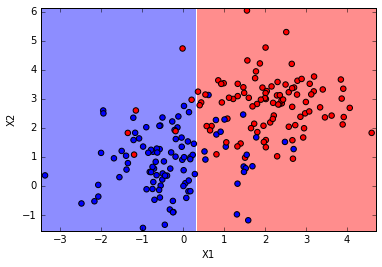

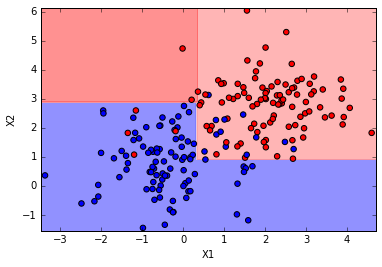

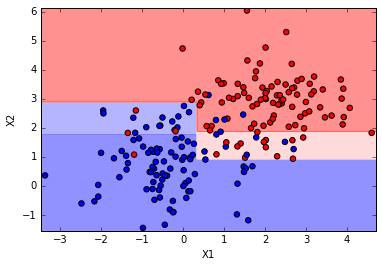

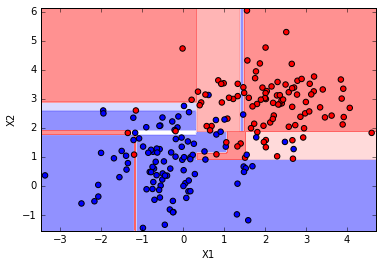

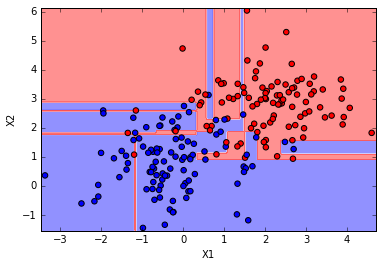

In [6]:
for depth in [1, 2, 3, 5, 10]:
    tree_clf = DecisionTreeClassifier(max_depth=depth)
    tree_clf.fit(X_toy, y_toy)
    plot_classifier_decision(tree_clf, X_toy, y_toy)
    plt.xlabel('X1'), plt.ylabel('X2')
    plt.show()

# Pre-stopping

**Exercise:** provide similar plots for min_samples_leaf=1, 2, 3, 5, 10.  <br />
Does it improve the model?

## Notes on Decision Tree:

- independent on features scale
- during classification decision tree returns probability
- pre-stopping matters (`max_depth`, `min_samples_leaf`)

## Logistic regression

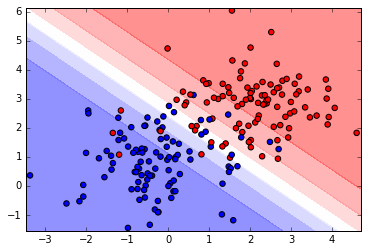

In [7]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression().fit(X_toy, y_toy)
plot_classifier_decision(clf, X_toy, y_toy)

# Back to flight delays

read data for training of trees and ensembles

In [8]:
data = ascii.read("data/training.csv", delimiter=',')  
test_kaggle = ascii.read("data/test.csv", delimiter=',')  

binary_target = (data['ARRIVAL_DELAY'] > 10) * 1
data.remove_column('ARRIVAL_DELAY')

### helping functions from the first notebook

In [9]:
def train_test_split(*arrays, **kargs):
    '''modification of sklearn's train_test_split to support astropy. See sklearn documentation for parameters '''
    from sklearn.cross_validation import train_test_split
    arrays2 = map(lambda x: numpy.array(x) if isinstance(x, Table) else x, arrays)
    results = list(train_test_split(*arrays2, **kargs))
    
    for i in range(len(results) // 2):
        if isinstance(arrays[i], Table):
            results[2 * i] = Table(results[2 * i])
            results[2 * i + 1] = Table(results[2 * i + 1])
    return results

In [10]:
from IPython.display import FileLink

def create_solution(predictions, filename='flight-delay-predictions.csv'):
    result = astropy.table.Table({'ID': numpy.arange(len(predictions)), 'ARRIVAL_DELAY': predictions})
    result.write('data/{}'.format(filename), format='csv', delimiter=',', overwrite=True)
    return FileLink('data/{}'.format(filename))

Take the same part of data as in the previous notebooks and preparing training and test parts

In [11]:
# take small part of data
small_data = data[::20]
small_binary_target = binary_target[::20]
print len(small_data)

# cross validation samples preparing
trainX, testX, trainY, testY = train_test_split(small_data, small_binary_target, random_state=42, train_size=0.5)

24994


/Users/axelr/.venvs/rep/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Data description

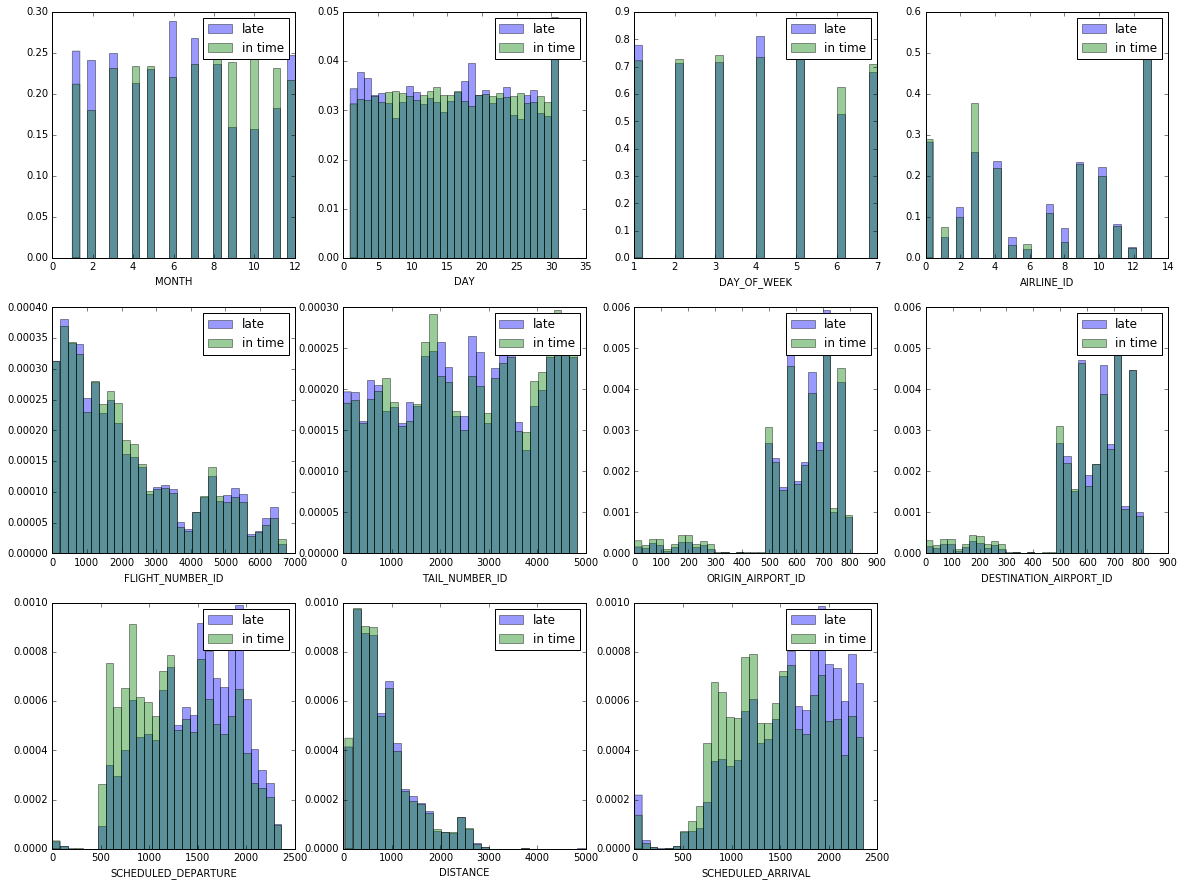

In [12]:
plt.figure(figsize=(20, 15))
for n, feature in enumerate(small_data.colnames):
    plt.subplot(3, 4, n + 1)
    plt.hist(data[binary_target == 1][feature], label='late', normed=True, bins=30, alpha=0.4)
    plt.hist(data[binary_target == 0][feature], label='in time', normed=True, bins=30, alpha=0.4)
    plt.xlabel(feature)
    plt.legend()

## KNN 

In [13]:
for n_neighbors in [1, 2, 4, 8, 16]:
    knn_clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn_clf.fit(trainX.to_pandas(), trainY)
    print n_neighbors, roc_auc_score(testY, knn_clf.predict_proba(testX.to_pandas())[:, 1])

1 0.515724003542
2 0.526811467497
4 0.54385364353
8 0.554350463052
16 0.568701112664


## Decision Tree

Unlimitted tree leads to overfitting

In [14]:
tree = DecisionTreeClassifier()
tree.fit(trainX.to_pandas(), trainY)
print 'train', roc_auc_score(trainY, tree.predict_proba(trainX.to_pandas())[:, 1])
print 'test ', roc_auc_score(testY, tree.predict_proba(testX.to_pandas())[:, 1])

train 1.0
test  0.534462665924


### Limit the depth (use pre-stopping)

In [15]:
tree = DecisionTreeClassifier(max_depth=6)
tree.fit(trainX.to_pandas(), trainY)
print 'train', roc_auc_score(trainY, tree.predict_proba(trainX.to_pandas())[:, 1])
print 'test ', roc_auc_score(testY, tree.predict_proba(testX.to_pandas())[:, 1])

train 0.665900493524
test  0.593524493646


## Combining predictions

In [16]:
classifiers = [
    DecisionTreeClassifier(max_depth=6),
    KNeighborsClassifier(n_neighbors=16),
]

for clf in classifiers:
    clf.fit(trainX.to_pandas(), trainY)
    print roc_auc_score(testY, clf.predict_proba(testX.to_pandas())[:, 1]), clf

0.593072397245 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
0.568701112664 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=16, p=2,
           weights='uniform')


**Averaging** predictions. We could use different coefficient to mix results

In [17]:
tree_predictions = classifiers[0].predict_proba(testX.to_pandas())[:, 1]
knn_predictions  = classifiers[1].predict_proba(testX.to_pandas())[:, 1]

averaged_predictions = tree_predictions * 0.5 + knn_predictions * 0.5
print roc_auc_score(testY, averaged_predictions)

0.597921285696


In [18]:
averaged_kaggle_predictions = classifiers[0].predict_proba(test_kaggle.to_pandas())[:, 1] * 0.5 + \
                              classifiers[1].predict_proba(test_kaggle.to_pandas())[:, 1] * 0.5

create_solution(averaged_kaggle_predictions, 
                filename='flight-delay-tree-knn.csv')

/Users/axelr/Yandex.Disk.localized/2017-04-Heidelberg/practice/data/flight-delay-tree-knn.csv

## kFolding 

One of cross-validation strategies, each sample is used once and only once in testing, so an estimate is more reliable! (of course it is slower)

In [19]:
from sklearn.cross_validation import KFold

qualities = []
for train_indices, test_indices in KFold(len(small_data), n_folds=3):
    fold_trainX = small_data[train_indices]
    fold_testX  = small_data[test_indices]
    fold_trainY = small_binary_target[train_indices]
    fold_testY  = small_binary_target[test_indices]

    tree_clf = DecisionTreeClassifier(max_depth=6)
    tree_clf.fit(fold_trainX.to_pandas(), fold_trainY)
    qualities.append(roc_auc_score(fold_testY, tree_clf.predict_proba(fold_testX.to_pandas())[:, 1]))
    
print qualities
print numpy.mean(qualities)
print numpy.std(qualities)

[0.61177158517133334, 0.61258038210624421, 0.60490449724108719]
0.60975215484
0.00344367790446


** For kaggle challenge**

1. Tune parameters of models with cross-validation, also with kFolding
2. Play with tree parameters to improve quality
3. (Extra) Split the data into two parts (50% each), on each part train a decision tree (with any parameters, but the same parameters for both trees!) and compare the structure of trees. Are they similar? <br /> (Below you have the code to display tree's structure)
4. Sometimes it is a good idea to mix several models, because those are catching different dependencies, <br />
   so mix up Knn, logistic regression and decision tree with appropriate coefficients to improve the quality.

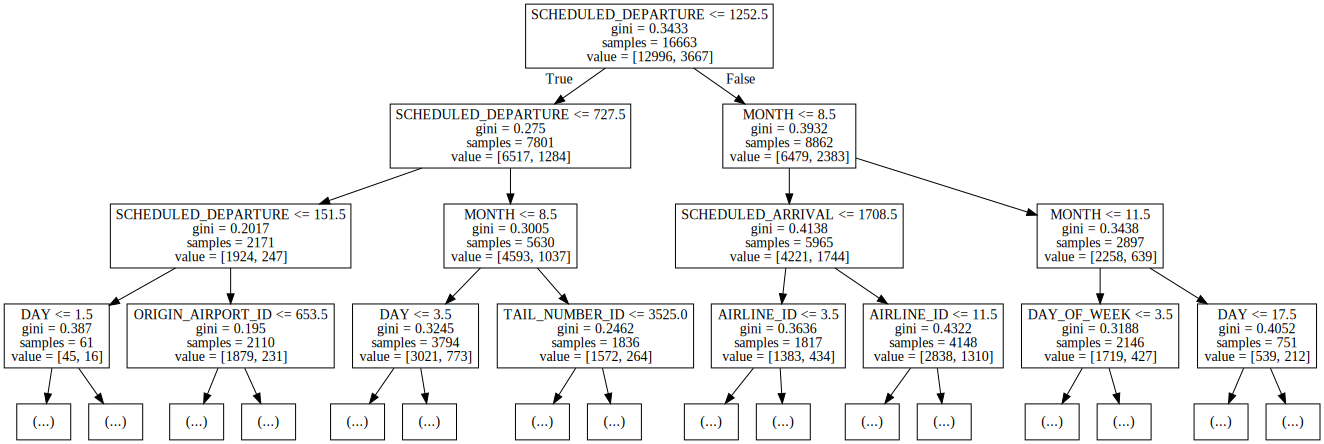

In [20]:
# if you want to observe the tree structure, you can use the following code
import pydot_ng
from six import StringIO
from sklearn.tree import export_graphviz
from IPython.display import SVG

def plot_tree(tree, columns, max_depth):
    dot_data = StringIO()
    export_graphviz(tree, out_file=dot_data, feature_names=columns, max_depth=max_depth)
    graph = pydot_ng.graph_from_dot_data(dot_data.getvalue())
    return SVG(graph.create_svg())

# If you have own installation of python, this may require installing graphviz and pydot-ng
plot_tree(tree_clf, trainX.colnames, max_depth=3)